## Set up 

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [4]:
%%R
# Load packages and prepare environment
library(tidyverse)
library(fixest)
library(ggplot2)


In [5]:
%%R
# Load the dataset
df <- read_csv("hmda_2021_2023_with_elections.csv")

# Create binary outcome


Rows: 53810560 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (26): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
nrow(df)

[1] 53810560


In [7]:
%%R
str(df)

spc_tbl_ [53,810,560 × 31] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ activity_year                    : num [1:53810560] 2021 2021 2021 2021 2021 ...
 $ lei                              : chr [1:53810560] "549300NWBS6MQJX15N44" "549300NWBS6MQJX15N44" "549300NWBS6MQJX15N44" "549300NWBS6MQJX15N44" ...
 $ state_code                       : chr [1:53810560] "MA" "FL" "TX" "TX" ...
 $ county_code                      : chr [1:53810560] "25017" "12001" "48085" "48181" ...
 $ derived_dwelling_category        : chr [1:53810560] "Single Family (1-4 Units):Site-Built" "Single Family (1-4 Units):Site-Built" "Single Family (1-4 Units):Site-Built" "Single Family (1-4 Units):Site-Built" ...
 $ action_taken                     : num [1:53810560] 6 6 1 1 1 1 1 6 1 1 ...
 $ loan_purpose                     : num [1:53810560] 31 1 32 32 1 32 4 31 1 32 ...
 $ lien_status                      : num [1:53810560] 1 1 1 1 1 1 1 1 1 1 ...
 $ loan_amount                      : num [1:53810560] 435000 455000 3

## without elections results - only in anti-DEI law states

Comparing black versus white/non-black for approval of mortgage before and after the anti-DEI law

black vs white 

In [9]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and filter for White and Black only
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(5, 3)  # 1 = White, 3 = Black only
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "White"),
    race = factor(race, levels = c("White", "Black")),  # White as reference
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, anti_dei_state, post, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Subset to treated (anti-DEI) states only
df_treated <- df_clean %>% filter(anti_dei_state == 1)

# Step 4: Fit the binomial model
model_black_vs_white <- feglm(
  approved ~ post * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_treated,
  family = "binomial",
  cluster = ~state_code
)

# Step 5: Output results
cat("\n📌 DiD Model: Black vs. White Applicants (Treated States Only)\n")
summary(model_black_vs_white)



📌 DiD Model: Black vs. White Applicants (Treated States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 4,936,066
Fixed-effects: county_code: 1,425,  activity_year: 3,  lei: 2,842
Standard-errors: Clustered (state_code) 
                   Estimate   Std. Error   z value  Pr(>|z|)    
post           -0.045037319 0.0148474777  -3.03333 0.0024187 ** 
raceBlack      -0.428319150 0.0253214181 -16.91529 < 2.2e-16 ***
income         -0.000103933 0.0000378939  -2.74275 0.0060927 ** 
loan_amount     0.000000152 0.0000000806   1.88643 0.0592376 .  
debt_to_income -0.000080733 0.0000082844  -9.74513 < 2.2e-16 ***
post:raceBlack  0.089713481 0.0288872391   3.10564 0.0018987 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,586,945.0   Adj. Pseudo R2: 0.065222
           BIC:  5,239,761.3     Squared Cor.: 0.079195


NOTE: 3/0/666 fixed-effects (5,995 observations) removed because of only 0 (or only 1) outcomes.


## use this, for anti-dei law only! between black vs white lenders 

In [27]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare cleaned HMDA data (Black vs. White only)
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)  # 3 = Black, 5 = White
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(`applicant_race-1` == 3 ~ "Black", `applicant_race-1` == 5 ~ "White"),
    race = factor(race, levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, post_law, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Run cleaner DiD model with post_law × race interaction
df_treated <- df_clean %>% filter(anti_dei_state == 1)

model_fixed <- feglm(
  approved ~ post_law * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_treated,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: Output
cat("\n📌 Fixed Model A: post_law × race (Treated States Only)\n")
summary(model_fixed)



📌 Fixed Model A: post_law × race (Treated States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 4,936,066
Fixed-effects: county_code: 1,425,  activity_year: 3,  lei: 2,842
Standard-errors: Clustered (state_code) 
                       Estimate   Std. Error   z value  Pr(>|z|)    
post_law           -0.045037319 0.0148474777  -3.03333 0.0024187 ** 
raceBlack          -0.428319150 0.0253214181 -16.91529 < 2.2e-16 ***
income             -0.000103933 0.0000378939  -2.74275 0.0060927 ** 
loan_amount         0.000000152 0.0000000806   1.88643 0.0592376 .  
debt_to_income     -0.000080733 0.0000082844  -9.74513 < 2.2e-16 ***
post_law:raceBlack  0.089713481 0.0288872391   3.10564 0.0018987 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,586,945.0   Adj. Pseudo R2: 0.065222
           BIC:  5,239,761.3     Squared Cor.: 0.079195


NOTE: 3/0/666 fixed-effects (5,995 observations) removed because of only 0 (or only 1) outcomes.


## anti-DEI states pre and post anti-dei law 

In [23]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare HMDA data (Black vs. White)
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(`applicant_race-1` == 3 ~ "Black", `applicant_race-1` == 5 ~ "White"),
    race = factor(race, levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    pre_law = ifelse(!is.na(law_date) & activity_date < law_date, 1, 0),
    post_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, pre_law, post_law, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Only treated states (anti-DEI passed)
df_treated <- df_clean %>% filter(anti_dei_state == 1)

# Step 4: Run model with pre/post law × race interaction
model_lawsplit <- feglm(
  approved ~ pre_law * race + post_law * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_treated,
  family = "binomial",
  cluster = ~state_code
)

# Step 5: Output
cat("\n📌 Model: Black vs. White before & after Anti-DEI Laws (Treated States Only)\n")
summary(model_lawsplit)



📌 Model: Black vs. White before & after Anti-DEI Laws (Treated States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 4,936,066
Fixed-effects: county_code: 1,425,  activity_year: 3,  lei: 2,842
Standard-errors: Clustered (state_code) 
                       Estimate   Std. Error   z value  Pr(>|z|)    
pre_law             0.045037320 1.482252e-02  3.038439 0.0023781 ** 
raceBlack          -0.771474751 1.486488e+03 -0.000519 0.9995859    
income             -0.000103933 3.789710e-05 -2.742514 0.0060971 ** 
loan_amount         0.000000152 8.060000e-08  1.886081 0.0592841 .  
debt_to_income     -0.000080733 8.285300e-06 -9.744143 < 2.2e-16 ***
pre_law:raceBlack   0.341659048 1.486483e+03  0.000230 0.9998166    
raceBlack:post_law  0.432514664 1.486468e+03  0.000291 0.9997678    
... 1 variable was removed because of collinearity (post_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,586,945.1   Adj. Pseudo R2: 0.065222


NOTE: 3/0/666 fixed-effects (5,995 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_law' has been removed because of collinearity (see $collin.var).


## black versus white anti-DEI x non anti-DEI 

In [118]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Filter and prepare treated states only
df_treated <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)  # 3 = Black, 5 = White
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = factor(case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ), levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  filter(!is.na(law_date)) %>%  # Only treated states
  mutate(
    post_law = ifelse(activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, post_law, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: DiD model for treated states
model_did <- feglm(
  approved ~ post_law * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_treated,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: Output
cat("\n📌 DiD Model: Treated States Only (post_law × race)\n")
summary(model_did)



📌 DiD Model: Treated States Only (post_law × race)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 4,936,066
Fixed-effects: county_code: 1,425,  activity_year: 3,  lei: 2,842
Standard-errors: Clustered (state_code) 
                       Estimate   Std. Error   z value  Pr(>|z|)    
post_law           -0.045037319 0.0148474777  -3.03333 0.0024187 ** 
raceBlack          -0.428319150 0.0253214181 -16.91529 < 2.2e-16 ***
income             -0.000103933 0.0000378939  -2.74275 0.0060927 ** 
loan_amount         0.000000152 0.0000000806   1.88643 0.0592376 .  
debt_to_income     -0.000080733 0.0000082844  -9.74513 < 2.2e-16 ***
post_law:raceBlack  0.089713481 0.0288872391   3.10564 0.0018987 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,586,945.0   Adj. Pseudo R2: 0.065222
           BIC:  5,239,761.3     Squared Cor.: 0.079195


NOTE: 3/0/666 fixed-effects (5,995 observations) removed because of only 0 (or only 1) outcomes.


## DiDiD anti vs non-anti states black vs white

In [120]:
%%R
library(tidyverse)
library(fixest)

# --- Step 1: Anti-DEI law dates ---
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(
    law_date = as.Date(law_date),
    treated = 1
  )

# --- Step 2: Merge into full dataset ---
df_all <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = factor(case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ), levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    treated = ifelse(is.na(treated), 0, 1),
    law_date = ifelse(is.na(law_date), as.Date("2099-01-01"), law_date),
    post_law = ifelse(activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# --- Step 3: DiDiD model ---
model_didid <- feglm(
  approved ~ treated * post_law * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_all,
  family = "binomial",
  cluster = ~state_code
)

# --- Step 4: Output ---
cat("\n📌 DiDiD Model: All States (treated × post_law × race)\n")
summary(model_didid)



📌 DiDiD Model: All States (treated × post_law × race)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 12,009,855
Fixed-effects: county_code: 3,211,  activity_year: 3,  lei: 4,689
Standard-errors: Clustered (state_code) 
                        Estimate   Std. Error    z value  Pr(>|z|)    
treated             0.3596945671 0.2150631879   1.672506 0.0944245 .  
post_law           -0.0231237504 0.0137243313  -1.684873 0.0920131 .  
raceBlack          -0.4671457908 0.0206669487 -22.603520 < 2.2e-16 ***
income             -0.0000135936 0.0000414318  -0.328095 0.7428396    
loan_amount         0.0000000489 0.0000000283   1.725972 0.0843525 .  
debt_to_income     -0.0000637125 0.0000058451 -10.900255 < 2.2e-16 ***
treated:raceBlack   0.0311915720 0.0337945292   0.922977 0.3560192    
post_law:raceBlack  0.0897173803 0.0284850294   3.149633 0.0016348 ** 
... 2 variables were removed because of collinearity (treated:post_law and treated:post_law:raceBlack)
---
Signif. code

NOTES: 317,213 observations removed because of NA values (vcov: 317,213).
       7/0/466 fixed-effects (19,595 observations) removed because of only 0 (or only 1) outcomes.
The variables 'treated:post_law' and 'treated:post_law:raceBlack' have been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 12,339,757.1. 


## placebo regression for 2021,2022

Approval trends for Black and White applicants moved in parallel in 2021–2022 in treated states, before any laws were passed

In [121]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Filter HMDA data to pre-policy years only (2021–2022)
df_placebo <- df %>%
  filter(
    activity_year %in% c(2021, 2022),
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)  # Black or White
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = factor(case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ), levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    placebo_post = ifelse(activity_year == 2022, 1, 0)  # pretend treatment in 2022
  ) %>%
  filter(anti_dei_state == 1 & activity_date < law_date) %>%  # restrict to treated states, pre-law only
  drop_na(approved, race, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Run placebo interaction model
model_placebo <- feglm(
  approved ~ placebo_post * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_placebo,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: Output
cat("\n📌 Placebo Regression (2021 vs. 2022 in Treated States — Pre-law only)\n")
summary(model_placebo)



📌 Placebo Regression (2021 vs. 2022 in Treated States — Pre-law only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 3,582,150
Fixed-effects: county_code: 1,423,  activity_year: 2,  lei: 2,511
Standard-errors: Clustered (state_code) 
                           Estimate   Std. Error   z value   Pr(>|z|)    
raceBlack              -0.437842103 0.0254974431 -17.17200  < 2.2e-16 ***
income                 -0.000078143 0.0000459863  -1.69926 8.9271e-02 .  
loan_amount             0.000000117 0.0000000899   1.30226 1.9283e-01    
debt_to_income         -0.000070249 0.0000089640  -7.83682 4.6209e-15 ***
placebo_post:raceBlack  0.020471995 0.0144353989   1.41818 1.5614e-01    
... 1 variable was removed because of collinearity (placebo_post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -1,851,926.3   Adj. Pseudo R2: 0.068622
           BIC:  3,763,298.0     Squared Cor.: 0.082647


NOTE: 4/0/529 fixed-effects (3,707 observations) removed because of only 0 (or only 1) outcomes.
The variable 'placebo_post' has been removed because of collinearity (see $collin.var).


## black vs non black 

In [14]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Updated anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare cleaned HMDA dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)  # Include full race spectrum
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "NonBlack"),
    race = factor(race, levels = c("NonBlack", "Black")),  # NonBlack is the reference
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, anti_dei_state, post, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Estimate model with additive fixed effects (county and year)
df_treated <- df_clean %>% filter(anti_dei_state == 1)

model_logit <- feglm(
  approved ~ post * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_treated,  # where anti_dei_state == 1
  family = "binomial",
  cluster = ~state_code
)
summary(model_logit)

GLM estimation, family = binomial, Dep. Var.: approved
Observations: 5,321,871
Fixed-effects: county_code: 1,427,  activity_year: 3,  lei: 2,874
Standard-errors: Clustered (state_code) 
                   Estimate   Std. Error   z value  Pr(>|z|)    
post           -0.039513273 0.0146924135  -2.68937 0.0071588 ** 
raceBlack      -0.393141468 0.0259365612 -15.15781 < 2.2e-16 ***
income         -0.000098859 0.0000335869  -2.94338 0.0032465 ** 
loan_amount     0.000000120 0.0000000654   1.82992 0.0672625 .  
debt_to_income -0.000082678 0.0000081680 -10.12224 < 2.2e-16 ***
post:raceBlack  0.065323004 0.0305410410   2.13886 0.0324470 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,813,856.2   Adj. Pseudo R2: 0.065246
           BIC:  5,694,431.7     Squared Cor.: 0.079537
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


NOTE: 3/0/660 fixed-effects (6,233 observations) removed because of only 0 (or only 1) outcomes.
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 5,627,712.3. 


## black versus non black, anti-DEI x non anti-DEI, this logic makes no sense!! 

In [42]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates (per state)
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare HMDA data (Black vs. NonBlack), merged with law dates
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "NonBlack"),
    race = factor(race, levels = c("NonBlack", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, anti_dei_state, post_law, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Estimate model with full 3-way interaction: post × anti-DEI × race
model_full_did <- feglm(
  approved ~ post_law * anti_dei_state * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_clean,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: Output results
cat("\n📌 FULL DiD Model: post_law × anti_dei_state × race (Black vs. NonBlack)\n")
summary(model_full_did)



📌 FULL DiD Model: post_law × anti_dei_state × race (Black vs. NonBlack)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 13,307,385
Fixed-effects: county_code: 3,215,  activity_year: 3,  lei: 4,728
Standard-errors: Clustered (state_code) 
                              Estimate   Std. Error    z value  Pr(>|z|)    
post_law                 -0.0128143103 0.0137333387  -0.933080  0.350778    
anti_dei_state            0.2516150354 0.2165044105   1.162170  0.245166    
raceBlack                -0.4323970479 0.0215931813 -20.024703 < 2.2e-16 ***
income                   -0.0000088841 0.0000261031  -0.340346  0.733596    
loan_amount               0.0000000210 0.0000000362   0.579264  0.562411    
debt_to_income           -0.0000667232 0.0000053905 -12.377999 < 2.2e-16 ***
post_law:raceBlack        0.0652467172 0.0301226999   2.166032  0.030309 *  
anti_dei_state:raceBlack  0.0324302509 0.0342319534   0.947368  0.343451    
... 2 variables were removed because of colline

NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       7/0/440 fixed-effects (24,895 observations) removed because of only 0 (or only 1) outcomes.
The variables 'post_law:anti_dei_state' and 'post_law:anti_dei_state:raceBlack' have been removed because of collinearity (see $collin.var).


## black versus non black non anti-DEI only 

In [109]:
%%R
df_control <- df_control %>%
  mutate(fake_post = ifelse(activity_year >= 2022, 1, 0))

model_placebo <- feglm(
  approved ~ fake_post * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_control,
  family = "binomial",
  cluster = ~state_code
)


NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       4/0/611 fixed-effects (21,941 observations) removed because of only 0 (or only 1) outcomes.
The variable 'fake_post' has been removed because of collinearity (see $collin.var).


In [44]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare cleaned HMDA dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "NonBlack"),
    race = factor(race, levels = c("NonBlack", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    fake_post = ifelse(anti_dei_state == 0 & activity_year >= 2022, 1, 0)  # Placebo post treatment
  ) %>%
  drop_na(approved, race, anti_dei_state, post, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Filter to non-anti-DEI states
df_control <- df_clean %>% filter(anti_dei_state == 0)

# Step 4: Run placebo test using fake_post
model_placebo <- feglm(
  approved ~ fake_post * race + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_control,
  family = "binomial",
  cluster = ~state_code
)

summary(model_placebo)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 7,982,235
Fixed-effects: county_code: 1,789,  activity_year: 3,  lei: 3,784
Standard-errors: Clustered (state_code) 
                         Estimate   Std. Error    z value  Pr(>|z|)    
raceBlack           -4.562730e-01 0.0238400815 -19.138901 < 2.2e-16 ***
income              -1.890600e-06 0.0000028490  -0.663589  0.506953    
loan_amount         -3.230000e-09 0.0000000192  -0.168541  0.866158    
debt_to_income      -5.936861e-05 0.0000053479 -11.101359 < 2.2e-16 ***
fake_post:raceBlack  3.501596e-02 0.0143777369   2.435429  0.014874 *  
... 1 variable was removed because of collinearity (fake_post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -4,083,149.7   Adj. Pseudo R2: 0.06206 
           BIC:  8,254,964.9     Squared Cor.: 0.074444


NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       4/0/611 fixed-effects (21,941 observations) removed because of only 0 (or only 1) outcomes.
The variable 'fake_post' has been removed because of collinearity (see $collin.var).


## racial disparities (Black vs. NonBlack) in mortgage approval shifted after anti-DEI law

to test whether the change in mortgage approval odds for Black applicants after anti-DEI laws was larger in states that passed those laws compared to states that didn’t.

In [91]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and prepare HMDA data
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)  # major racial categories
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "NonBlack"),
    race = factor(race, levels = c("NonBlack", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, anti_dei_state, post, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Run pooled DiD model with triple interaction
model_did3 <- feglm(
  approved ~ race * post * anti_dei_state + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_clean,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: View model summary
summary(model_did3)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 13,307,385
Fixed-effects: county_code: 3,215,  activity_year: 3,  lei: 4,728
Standard-errors: Clustered (state_code) 
                              Estimate   Std. Error    z value  Pr(>|z|)    
raceBlack                -0.4323970479 0.0215931813 -20.024703 < 2.2e-16 ***
post                     -0.0128143103 0.0137333387  -0.933080  0.350778    
anti_dei_state            0.2516150354 0.2165044105   1.162170  0.245166    
income                   -0.0000088841 0.0000261031  -0.340346  0.733596    
loan_amount               0.0000000210 0.0000000362   0.579264  0.562411    
debt_to_income           -0.0000667232 0.0000053905 -12.377999 < 2.2e-16 ***
raceBlack:post            0.0652467172 0.0301226999   2.166032  0.030309 *  
raceBlack:anti_dei_state  0.0324302509 0.0342319534   0.947368  0.343451    
... 2 variables were removed because of collinearity (post:anti_dei_state and raceBlack:post:anti_dei_state)
---
Signif.

NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       7/0/440 fixed-effects (24,895 observations) removed because of only 0 (or only 1) outcomes.
The variables 'post:anti_dei_state' and 'raceBlack:post:anti_dei_state' have been removed because of collinearity (see $collin.var).


In [111]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare cleaned dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)  # All major races
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    raceBlack = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post2022 = ifelse(activity_year >= 2022, 1, 0)
  ) %>%
  drop_na(approved, raceBlack, anti_dei_state, post2022,
          income, loan_amount, debt_to_income, lei, activity_year)

# Step 3: Estimate DiDiD model with simplified post
model_did3_simple <- feglm(
  approved ~ raceBlack * post2022 * anti_dei_state + income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_clean,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: View results
summary(model_did3_simple)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 13,307,410
Fixed-effects: activity_year: 3,  lei: 4,728
Standard-errors: Clustered (state_code) 
                                       Estimate   Std. Error    z value
raceBlack                         -4.723493e-01 0.0297246956 -15.890804
anti_dei_state                    -1.242799e-01 0.0532894663  -2.332167
income                            -1.112127e-05 0.0000282113  -0.394213
loan_amount                        1.190000e-09 0.0000000201   0.059012
debt_to_income                    -6.830014e-05 0.0000053441 -12.780531
raceBlack:post2022                 3.288725e-02 0.0141645388   2.321802
raceBlack:anti_dei_state           4.600497e-02 0.0373796740   1.230748
post2022:anti_dei_state            2.399069e-02 0.0179244275   1.338436
raceBlack:post2022:anti_dei_state  7.783061e-03 0.0250722321   0.310426
                                   Pr(>|z|)    
raceBlack                         < 2.2e-16 ***
anti_dei_state    

NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       0/440 fixed-effects (24,870 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post2022' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 14,002,468.6. 


In [93]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and prepare HMDA data
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)  # major racial categories
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = ifelse(`applicant_race-1` == 3, "Black", "NonBlack"),
    race = factor(race, levels = c("NonBlack", "Black")),
    raceBlack = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0)
  ) %>%
  drop_na(approved, race, anti_dei_state, post, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Run pooled DiD model with triple interaction
df_dei <- df_clean %>% filter(anti_dei_state == 1)

model_dei <- feglm(
  approved ~ raceBlack * post + income + loan_amount + debt_to_income |
    lei + activity_year,
  data = df_dei,
  family = "binomial",
  cluster = ~state_code
)

summary(model_dei)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 5,321,889
Fixed-effects: lei: 2,874,  activity_year: 3
Standard-errors: Clustered (state_code) 
                    Estimate   Std. Error   z value  Pr(>|z|)    
raceBlack      -0.3971616723 0.0223893316 -17.73888 < 2.2e-16 ***
post           -0.1571599077 0.0556581023  -2.82367 0.0047478 ** 
income         -0.0001023024 0.0000331182  -3.08901 0.0020083 ** 
loan_amount     0.0000000763 0.0000000692   1.10278 0.2701233    
debt_to_income -0.0000819727 0.0000073237 -11.19272 < 2.2e-16 ***
raceBlack:post  0.0599364937 0.0259188662   2.31247 0.0207520 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,851,683.9   Adj. Pseudo R2: 0.053174
           BIC:  5,748,002.4     Squared Cor.: 0.064521
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


NOTE: 660/0 fixed-effects (6,215 observations) removed because of only 0 (or only 1) outcomes.
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 5,703,367.9. 


In [95]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and prepare HMDA data
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    raceBlack = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = case_when(
      anti_dei_state == 1 & activity_date >= law_date ~ 1,
      anti_dei_state == 1 & activity_date < law_date  ~ 0,
      anti_dei_state == 0 & activity_year >= 2022     ~ 1,
      anti_dei_state == 0 & activity_year == 2021     ~ 0,
      TRUE ~ NA_real_
    )
  ) %>%
  drop_na(approved, raceBlack, anti_dei_state, post, income, loan_amount, debt_to_income, lei, activity_year)

# Step 3: Split into DEI and control groups
df_dei <- df_clean %>% filter(anti_dei_state == 1)
df_control <- df_clean %>% filter(anti_dei_state == 0)

# Step 4: Run GLM in DEI states
model_dei <- feglm(
  approved ~ raceBlack * post + income + loan_amount + debt_to_income |
    lei + activity_year,
  data = df_dei,
  family = "binomial",
  cluster = ~state_code
)

# Step 5: Run GLM in control states
model_control <- feglm(
  approved ~ raceBlack * post + income + loan_amount + debt_to_income |
    lei + activity_year,
  data = df_control,
  family = "binomial",
  cluster = ~state_code
)

# Step 6: Output summaries
summary(model_dei)
summary(model_control)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 7,982,242
Fixed-effects: lei: 3,784,  activity_year: 3
Standard-errors: Clustered (state_code) 
                    Estimate   Std. Error    z value  Pr(>|z|)    
raceBlack      -0.4756564411 0.0292449425 -16.264571 < 2.2e-16 ***
income         -0.0000020100 0.0000029957  -0.670938  0.502260    
loan_amount    -0.0000000234 0.0000000337  -0.693830  0.487789    
debt_to_income -0.0000617730 0.0000057062 -10.825517 < 2.2e-16 ***
raceBlack:post  0.0329181229 0.0141480682   2.326687  0.019982 *  
... 1 variable was removed because of collinearity (post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -4,140,905.7   Adj. Pseudo R2: 0.049221
           BIC:  8,342,060.6     Squared Cor.: 0.058556
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


NOTE: 660/0 fixed-effects (6,215 observations) removed because of only 0 (or only 1) outcomes.
NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       611/0 fixed-effects (21,934 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 5,703,367.9. 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 8,281,811.3. 


## White vs. Non-White DiD Model

In [98]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and prepare HMDA data
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    whiteApplicant = ifelse(`applicant_race-1` == 5, 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post = case_when(
      anti_dei_state == 1 & activity_date >= law_date ~ 1,
      anti_dei_state == 1 & activity_date < law_date  ~ 0,
      anti_dei_state == 0 & activity_year >= 2022     ~ 1,
      anti_dei_state == 0 & activity_year == 2021     ~ 0,
      TRUE ~ NA_real_
    )
  ) %>%
  drop_na(approved, whiteApplicant, post, anti_dei_state, income, loan_amount, debt_to_income, lei, activity_year)

# Step 3: Run pooled DiD model for White applicants
model_white <- feglm(
  approved ~ whiteApplicant * post + income + loan_amount + debt_to_income |
    lei + activity_year,
  data = df_clean,
  family = "binomial",
  cluster = ~state_code
)

# Step 4: View results
summary(model_white)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 13,307,410
Fixed-effects: lei: 4,728,  activity_year: 3
Standard-errors: Clustered (state_code) 
                         Estimate   Std. Error    z value  Pr(>|z|)    
whiteApplicant       0.3688562900 0.0254630877  14.485921 < 2.2e-16 ***
post                 0.0613406974 0.0375259055   1.634623  0.102128    
income              -0.0000129369 0.0000310126  -0.417150  0.676569    
loan_amount          0.0000000531 0.0000000250   2.128782  0.033272 *  
debt_to_income      -0.0000662720 0.0000050281 -13.180433 < 2.2e-16 ***
whiteApplicant:post -0.0167086924 0.0143929310  -1.160896  0.245684    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -7,000,887.9   Adj. Pseudo R2: 0.050498
           BIC: 14,079,464.3     Squared Cor.: 0.060281


NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       440/0 fixed-effects (24,870 observations) removed because of only 0 (or only 1) outcomes.


## White vs non-White anti-DEI vs non anti-DEI states (2 different models) 

In [105]:
%%R
# Step 0: Make sure whiteApplicant is defined
df_clean <- df_clean %>%
  mutate(
    whiteApplicant = ifelse(`applicant_race-1` == 5, 1, 0)
  )

# Step 1: Anti-DEI states → use actual post timing
df_dei <- df_clean %>% filter(anti_dei_state == 1)

model_white_dei <- feglm(
  approved ~ whiteApplicant * post + income + loan_amount + debt_to_income |
    lei + activity_year + county_code,
  data = df_dei,
  family = "binomial",
  cluster = ~state_code
)

# Step 2: Non-DEI states → use placebo post timing
df_control <- df_clean %>% 
  filter(anti_dei_state == 0) %>%
  mutate(fake_post = ifelse(activity_year >= 2022, 1, 0))

model_white_control <- feglm(
  approved ~ whiteApplicant * fake_post + income + loan_amount + debt_to_income |
    lei + activity_year + county_code,
  data = df_control,
  family = "binomial",
  cluster = ~state_code
)

# Step 3: Output summaries
summary(model_white_dei)
summary(model_white_control)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 7,982,235
Fixed-effects: lei: 3,784,  activity_year: 3,  county_code: 1,789
Standard-errors: Clustered (state_code) 
                              Estimate   Std. Error    z value  Pr(>|z|)    
whiteApplicant            3.523179e-01 0.0377726791   9.327321 < 2.2e-16 ***
income                   -1.816670e-06 0.0000028581  -0.635623   0.52502    
loan_amount               1.800000e-09 0.0000000130   0.138899   0.88953    
debt_to_income           -5.829931e-05 0.0000053917 -10.812819 < 2.2e-16 ***
whiteApplicant:fake_post  7.746577e-03 0.0154924784   0.500022   0.61706    
... 1 variable was removed because of collinearity (fake_post)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -4,081,825.0   Adj. Pseudo R2: 0.062364
           BIC:  8,252,315.5     Squared Cor.: 0.07473 
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


NOTE: 660/0/3 fixed-effects (6,233 observations) removed because of only 0 (or only 1) outcomes.
NOTES: 347,794 observations removed because of NA values (vcov: 347,794).
       611/0/4 fixed-effects (21,941 observations) removed because of only 0 (or only 1) outcomes.
The variable 'fake_post' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 5,622,599.2. 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 8,163,649.9. 


In [106]:
%%R
summary(model_white_dei)

GLM estimation, family = binomial, Dep. Var.: approved
Observations: 5,321,871
Fixed-effects: lei: 2,874,  activity_year: 3,  county_code: 1,427
Standard-errors: Clustered (state_code) 
                        Estimate   Std. Error  z value   Pr(>|z|)    
whiteApplicant       0.387288622 0.0260830095 14.84831  < 2.2e-16 ***
post                 0.053625235 0.0267330013  2.00596 0.04486090 *  
income              -0.000100486 0.0000349999 -2.87105 0.00409112 ** 
loan_amount          0.000000136 0.0000000710  1.91422 0.05559181 .  
debt_to_income      -0.000081677 0.0000082615 -9.88643  < 2.2e-16 ***
whiteApplicant:post -0.105732238 0.0278722043 -3.79347 0.00014856 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -2,811,299.6   Adj. Pseudo R2: 0.066094
           BIC:  5,689,318.6     Squared Cor.: 0.080495
# Evaluations: lhs: 25 -- no convergence: Maximum number of iterations reached 


In [18]:
%%R
library(fixest)
emmeans::emmeans(model_logit, ~ race | post, type = "response")

post = 0:
 race      prob      SE  df asymp.LCL asymp.UCL
 NonBlack 0.757 0.00657 Inf     0.744     0.770
 Black    0.680 0.00365 Inf     0.673     0.687

post = 1:
 race      prob      SE  df asymp.LCL asymp.UCL
 NonBlack 0.750 0.00887 Inf     0.732     0.767
 Black    0.684 0.00802 Inf     0.669     0.700

Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 


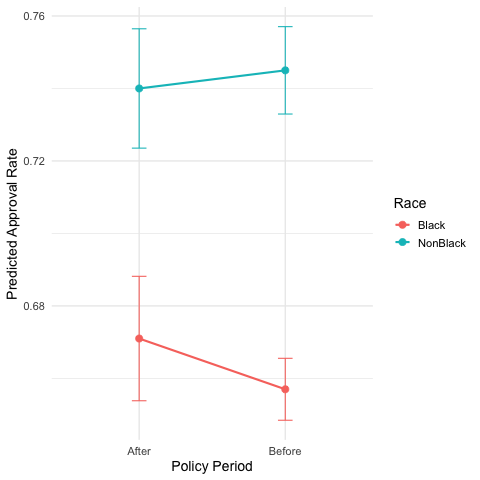

In [20]:
%%R
library(ggplot2)

# Data: Predicted approval rates and standard errors from emmeans
emmeans_results <- data.frame(
  post = rep(c("Before", "After"), each = 2),
  race = c("NonBlack", "Black", "NonBlack", "Black"),
  prob = c(0.745, 0.657, 0.740, 0.671),
  SE = c(0.00615, 0.00436, 0.00840, 0.00876)
)

# Optional: Reverse factor levels so "After" appears leftmost
emmeans_results$post <- factor(emmeans_results$post, levels = c("After", "Before"))

# Plot
ggplot(emmeans_results, aes(x = post, y = prob, color = race, group = race)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  geom_errorbar(aes(ymin = prob - 1.96 * SE, ymax = prob + 1.96 * SE), width = 0.1) +
  labs(
    y = "Predicted Approval Rate",
    x = "Policy Period",
    color = "Race"
  ) +
  theme_minimal(base_size = 14)


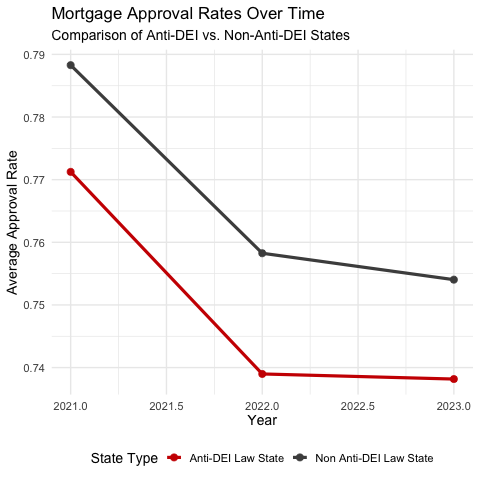

In [51]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law states
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    trump_majority = ifelse(per_point_diff > 0, 1, 0),
    trump_label = ifelse(trump_majority == 1, "Trump Majority", "Trump Minority")
  ) %>%
  drop_na(approved, anti_dei_state, per_point_diff)

# Step 3: Group for overall trend (no facet)
approval_trend <- df_clean %>%
  group_by(activity_year, anti_dei_state) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(
    anti_dei_label = ifelse(anti_dei_state == 1, "Anti-DEI Law State", "Non Anti-DEI Law State")
  )

# Step 4: Plot side-by-side comparison
ggplot(approval_trend, aes(x = activity_year, y = approval_rate, color = anti_dei_label)) +
  geom_line(size = 1.5) +
  geom_point(size = 3) +
  scale_color_manual(
    values = c("Anti-DEI Law State" = "red3", "Non Anti-DEI Law State" = "gray30")
  ) +
  labs(
    title = "Mortgage Approval Rates Over Time",
    subtitle = "Comparison of Anti-DEI vs. Non-Anti-DEI States",
    x = "Year",
    y = "Average Approval Rate",
    color = "State Type"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom")


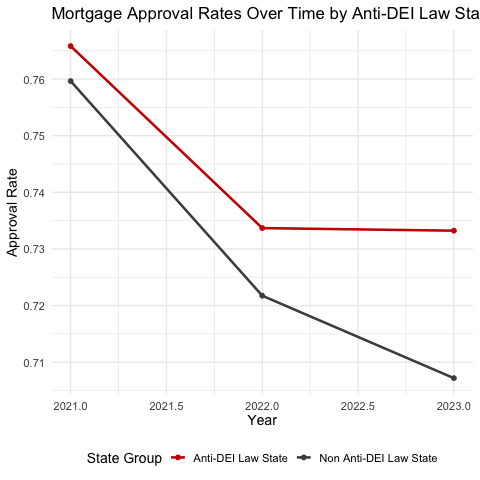

In [52]:
%%R
library(tidyverse)

# Step 1: Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Prepare and clean the dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0)
  ) %>%
  drop_na(approved, anti_dei_state, income, loan_amount, debt_to_income, county_code, lei, activity_year)

# Step 3: Aggregate approval rates by anti-DEI status and year
approval_rates <- df_clean %>%
  group_by(activity_year, anti_dei_state) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(
    anti_dei_label = ifelse(anti_dei_state == 1, "Anti-DEI Law State", "Non Anti-DEI Law State")
  )

# Step 4: Plot approval rates over time
ggplot(approval_rates, aes(x = activity_year, y = approval_rate, color = anti_dei_label)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_manual(
    values = c("Anti-DEI Law State" = "red3", "Non Anti-DEI Law State" = "gray30")
  ) +
  labs(
    title = "Mortgage Approval Rates Over Time by Anti-DEI Law Status",
    x = "Year",
    y = "Approval Rate",
    color = "State Group"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom")


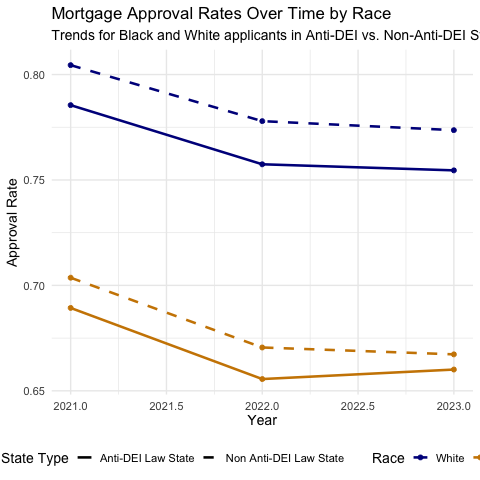

In [53]:
%%R
library(tidyverse)
library(fixest)

# Step 1: Define anti-DEI law states
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and enrich dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)  # Black or White only
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ),
    race = factor(race, levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    trump_majority = ifelse(per_point_diff > 0, 1, 0),
    trump_label = ifelse(trump_majority == 1, "Trump Majority", "Trump Minority")
  ) %>%
  drop_na(approved, anti_dei_state, per_point_diff)

# Step 3: Group by year, DEI law status, and race
approval_trend_race <- df_clean %>%
  group_by(activity_year, anti_dei_state, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(
    anti_dei_label = ifelse(anti_dei_state == 1, "Anti-DEI Law State", "Non Anti-DEI Law State")
  )

# Step 4: Plot trends by race and DEI law status
ggplot(approval_trend_race, aes(x = activity_year, y = approval_rate, color = race, linetype = anti_dei_label)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_manual(values = c("White" = "blue4", "Black" = "orange3")) +
  scale_linetype_manual(values = c("Anti-DEI Law State" = "solid", "Non Anti-DEI Law State" = "dashed")) +
  labs(
    title = "Mortgage Approval Rates Over Time by Race",
    subtitle = "Trends for Black and White applicants in Anti-DEI vs. Non-Anti-DEI States",
    x = "Year",
    y = "Approval Rate",
    color = "Race",
    linetype = "State Type"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom")


In [58]:
%%R
library(tidyverse)
library(fixest)
library(ggtext)  # for rich facet strip formatting

# Step 1: Define anti-DEI law states
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Filter and enrich HMDA dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ),
    race = factor(race, levels = c("White", "Black")),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    facet_label = ifelse(
      anti_dei_state == 1,
      paste0("<span style='color:red;'>", state_code, " (Anti-DEI)</span>"),
      state_code
    )
  ) %>%
  drop_na(approved, race, anti_dei_state)

# Step 3: Aggregate approval rates
approval_by_state <- df_clean %>%
  group_by(activity_year, state_code, race, facet_label) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  )

# Step 4: Plot
p <- ggplot(approval_by_state, aes(x = activity_year, y = approval_rate, color = race)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  facet_wrap(~ facet_label, ncol = 4) +
  scale_color_manual(values = c("White" = "blue4", "Black" = "orange3")) +
  labs(
    title = "Mortgage Approval Rates by Race Across States",
    subtitle = "Each panel shows Black vs. White approval trends (2021–2023)",
    x = "Year",
    y = "Approval Rate",
    color = "Race",
    caption = "🔴 State name in red indicates passage of an anti-DEI law between 2022–2025."
  ) +
  theme_minimal(base_size = 13) +
  theme(
    strip.text = element_markdown(face = "bold", size = 10),
    legend.position = "bottom",
    plot.caption = element_text(size = 10, hjust = 0.5)
  )

# Save the plot
ggsave("approval_by_race_facet.png", p, width = 14, height = 22, dpi = 300)


In [129]:
%%R
library(tidyverse)
library(ggtext)

# Step 1: Define anti-DEI law states
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Filter and clean dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` == 3  # Black applicants only
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(anti_dei_state = !is.na(law_date)) %>%
  filter(anti_dei_state == TRUE)  # Keep only states that passed anti-DEI laws

# Step 3: Determine pre/post periods and approval rates
approval_change <- df_clean %>%
  mutate(period = ifelse(activity_date < law_date, "Before", "After")) %>%
  filter(period %in% c("Before", "After")) %>%
  group_by(state_code, period) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(names_from = period, values_from = approval_rate) %>%
  drop_na(Before, After) %>%
  mutate(
    change = After - Before,
    trend = case_when(
      change > 0.005 ~ "Slight increase",
      change < -0.005 ~ "Slight decrease",
      TRUE ~ "No change"
    )
  )

# Step 4: Prepare long format for slope chart
slope_data <- approval_change %>%
  pivot_longer(cols = c(Before, After), names_to = "period", values_to = "approval_rate")

# Step 5: Plot
ggplot(slope_data, aes(x = period, y = approval_rate, group = state_code)) +
  geom_line(aes(color = trend), size = 1) +
  geom_point(size = 2, aes(color = trend)) +
  facet_wrap(~ trend, scales = "free_y") +
  scale_color_manual(values = c(
    "Slight increase" = "forestgreen",
    "Slight decrease" = "firebrick",
    "No change" = "gray40"
  )) +
  labs(
    title = "Change in Black Mortgage Approval Rates Before vs After Anti-DEI Laws",
    subtitle = "Grouped by direction of change in approval rate",
    x = "", y = "Approval Rate",
    caption = "Each line represents one anti-DEI state. Based on HMDA data 2021–2023."
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "none")

# Optional: Save
ggsave("black_approval_slopechart.png", width = 12, height = 8, dpi = 300)


## Mapping 

In [60]:
%%R
library(tidyverse)

# Step 1: Define updated anti-DEI states
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and enrich main dataset
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(3, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ),
    debt_to_income = loan_amount / income,
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    party_lean = ifelse(per_point_diff > 0, "Republican", "Democratic")
  ) %>%
  drop_na(approved, race, anti_dei_state, per_point_diff)

# Step 3: Aggregate approval rates
approval_by_state_year_race <- df_clean %>%
  group_by(state_code, activity_year, race, anti_dei_state, party_lean) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  )

# Step 4: Save CSV to disk
write_csv(approval_by_state_year_race, "approval_by_state_year_race_updated.csv")


In [63]:
%%R
library(tidyverse)

# Define states with anti-DEI laws and their enactment dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# List of all U.S. state codes
all_states <- state.abb

# Create a dataframe for all states
state_data <- tibble(state_code = all_states) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0)
  )

# Assuming you have a dataframe 'df' with 'state_code' and 'per_point_diff' columns
# Calculate average per_point_diff per state
state_political_lean <- df %>%
  group_by(state_code) %>%
  summarise(per_point_diff = mean(per_point_diff, na.rm = TRUE)) %>%
  mutate(party_lean = ifelse(per_point_diff > 0, "Republican", "Democratic"))

# Merge political leaning into state_data
state_data <- state_data %>%
  left_join(state_political_lean, by = "state_code")

# Save to CSV
write_csv(state_data, "state_dei_status.csv")


In [131]:
%%R
install.packages(c("tidyverse", "sf", "tigris"))

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 1) [https]
16: China (Beijing 2) [https]
17: China (Beijing 3) [https]
18: China (Hefei) [https]
19: China (Hong Kong) [https]
20: China (Jinan) [https]
21: China (Lanzhou) [https]
22: China (Nanjing) [https]
23: China (Shanghai 2) [https]
24: China (Shenzhen) [https]
25: China (Wuhan) [https]
26: Colombia (Cali) [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: Finland (Helsinki) [https]
33: France (Lyon 1) [https]
34: France (L

Selection:  66



The downloaded binary packages are in
	/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T//RtmpqaWR4V/downloaded_packages


trying URL 'https://cran.ma.imperial.ac.uk/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
Content type 'application/x-gzip' length 428901 bytes (418 KB)
downloaded 418 KB

trying URL 'https://cran.ma.imperial.ac.uk/bin/macosx/big-sur-arm64/contrib/4.4/sf_1.0-21.tgz'
Content type 'application/x-gzip' length 29666276 bytes (28.3 MB)
downloaded 28.3 MB

trying URL 'https://cran.ma.imperial.ac.uk/bin/macosx/big-sur-arm64/contrib/4.4/tigris_2.2.1.tgz'
Content type 'application/x-gzip' length 380941 bytes (372 KB)
downloaded 372 KB

In addition: Warning message:
In doTryCatch(return(expr), name, parentenv, handler) :
  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <34C5A480-1AC4-30DF-83C9-30A913FC042E> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: trie

In [132]:
%%R
library(tidyverse)
library(sf)
library(tigris)    # for state shapes
options(tigris_use_cache = TRUE)

# Step 1: Define anti-DEI law states (dates included but not used directly)
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Clean and filter to Black applicants only (2021–2023)
df_clean <- df %>%
  filter(
    activity_year %in% c(2021, 2023),
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` == 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0)
  ) %>%
  drop_na(approved)

# Step 3: Compute approval rate change per state from 2021 to 2023
approval_change <- df_clean %>%
  group_by(state_code, activity_year) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(names_from = activity_year, values_from = approval_rate, names_prefix = "year_") %>%
  mutate(change = year_2023 - year_2021) %>%
  drop_na(change)

# Step 4: Load US shapefile using tigris
states_sf <- tigris::states(cb = TRUE) %>%
  filter(!state_abbr %in% c("PR", "VI", "GU", "MP", "AS", "DC")) %>%
  select(state_code = STUSPS, geometry)

# Step 5: Merge map data with approval rate changes
map_data <- left_join(states_sf, approval_change, by = "state_code")

# Step 6: Plot
ggplot(map_data) +
  geom_sf(aes(fill = change), color = "white", size = 0.2) +
  scale_fill_gradient2(
    low = "lightblue",
    mid = "white",
    high = "darkblue",
    midpoint = 0,
    name = "Change in Approval Rate"
  ) +
  labs(
    title = "Change in Black Mortgage Approval Rates by State",
    subtitle = "From 2021 to 2023, based on HMDA data",
    caption = "Darker blue = increase; lighter blue = decrease in approval rate\nStates with missing data shown in gray."
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "right")

# Optional: Save
ggsave("black_approval_map_2021_2023.png", width = 10, height = 6, dpi = 300)


  |======================================================================| 100%
Error in `stopifnot()`:
ℹ In argument: `!state_abbr %in% c("PR", "VI", "GU", "MP", "AS", "DC")`.
Caused by error:
! object 'state_abbr' not found
Run `rlang::last_trace()` to see where the error occurred.
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.
Retrieving data for the year 2024
Error in stopifnot(!inherits(x, "sf"), !missing(sf_column_name), !missing(agr)) : 
  
Caused by error:
! object 'state_abbr' not found


RInterpreterError: Failed to parse and evaluate line 'library(tidyverse)\nlibrary(sf)\nlibrary(tigris)    # for state shapes\noptions(tigris_use_cache = TRUE)\n\n# Step 1: Define anti-DEI law states (dates included but not used directly)\nanti_dei_law_dates <- tribble(\n  ~state_code, ~law_date,\n  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",\n  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",\n  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",\n  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",\n  "WV", "2025-01-14"\n) %>%\n  mutate(law_date = as.Date(law_date))\n\n# Step 2: Clean and filter to Black applicants only (2021–2023)\ndf_clean <- df %>%\n  filter(\n    activity_year %in% c(2021, 2023),\n    loan_purpose == 1,\n    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",\n    occupancy_type == 1,\n    income > 0,\n    `applicant_race-1` == 3\n  ) %>%\n  mutate(\n    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0)\n  ) %>%\n  drop_na(approved)\n\n# Step 3: Compute approval rate change per state from 2021 to 2023\napproval_change <- df_clean %>%\n  group_by(state_code, activity_year) %>%\n  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop") %>%\n  pivot_wider(names_from = activity_year, values_from = approval_rate, names_prefix = "year_") %>%\n  mutate(change = year_2023 - year_2021) %>%\n  drop_na(change)\n\n# Step 4: Load US shapefile using tigris\nstates_sf <- tigris::states(cb = TRUE) %>%\n  filter(!state_abbr %in% c("PR", "VI", "GU", "MP", "AS", "DC")) %>%\n  select(state_code = STUSPS, geometry)\n\n# Step 5: Merge map data with approval rate changes\nmap_data <- left_join(states_sf, approval_change, by = "state_code")\n\n# Step 6: Plot\nggplot(map_data) +\n  geom_sf(aes(fill = change), color = "white", size = 0.2) +\n  scale_fill_gradient2(\n    low = "lightblue",\n    mid = "white",\n    high = "darkblue",\n    midpoint = 0,\n    name = "Change in Approval Rate"\n  ) +\n  labs(\n    title = "Change in Black Mortgage Approval Rates by State",\n    subtitle = "From 2021 to 2023, based on HMDA data",\n    caption = "Darker blue = increase; lighter blue = decrease in approval rate\\nStates with missing data shown in gray."\n  ) +\n  theme_minimal(base_size = 13) +\n  theme(legend.position = "right")\n\n# Optional: Save\nggsave("black_approval_map_2021_2023.png", width = 10, height = 6, dpi = 300)\n'.
R error message: 'Error in stopifnot(!inherits(x, "sf"), !missing(sf_column_name), !missing(agr)) : \n  \nCaused by error:\n! object \'state_abbr\' not found'
R stdout:
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.
Retrieving data for the year 2024

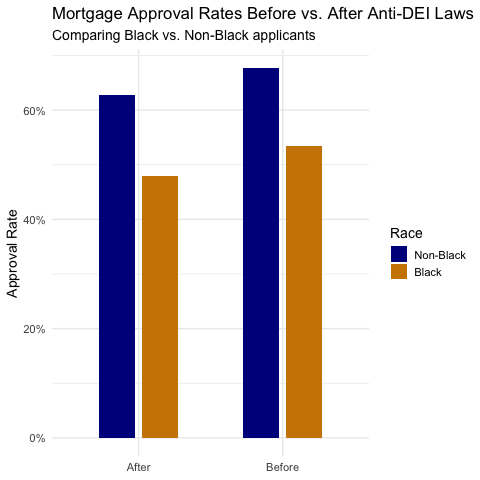

In [82]:
%%R
library(tidyverse)

# Step 1: Anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08", "TX", "2023-03-10",
  "IA", "2023-03-01", "ND", "2023-04-24", "UT", "2024-01-17", "AR", "2023-03-13",
  "NC", "2023-12-05", "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19", "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Step 2: Merge law_date into main dataset + create period indicator
df_plot <- df %>%
  mutate(
    activity_date = as.Date(paste0(activity_year, "-01-01")),
    
    # Step 1: Define approval
    approved = if_else(action_taken %in% c(1, 2, 6), 1, 0),
    
    # Step 2: Define race group
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ "Non-Black"
    )
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    period = case_when(
      is.na(law_date) ~ "No Law",
      activity_date < law_date ~ "Before",
      activity_date >= law_date ~ "After"
    ),
    race_group = factor(race, levels = c("Non-Black", "Black"))
  ) %>%
  filter(period != "No Law") %>%
  group_by(period, race_group) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  )


# Step 3: Plot grouped bar chart
ggplot(df_plot, aes(x = period, y = approval_rate, fill = race_group)) +
  geom_col(position = position_dodge(width = 0.6), width = 0.5) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_fill_manual(values = c("Black" = "orange3", "Non-Black" = "blue4")) +
  labs(
    title = "Mortgage Approval Rates Before vs. After Anti-DEI Laws",
    subtitle = "Comparing Black vs. Non-Black applicants",
    x = NULL, y = "Approval Rate",
    fill = "Race"
  ) +
  theme_minimal(base_size = 14)



In [128]:
%%R
library(tidyverse)

# Step 1: Data prep
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ "Non-Black"
    )
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), "Anti-DEI State", "Non-Anti-DEI State")
  ) %>%
  drop_na(approved, race, anti_dei_state)

# Step 2: Aggregate approval rates
approval_trends <- df_clean %>%
  group_by(activity_year, race, anti_dei_state) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop")

# Step 3: Plot the line chart
ggplot(approval_trends, aes(x = activity_year, y = approval_rate, color = race, linetype = anti_dei_state)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_manual(values = c("Black" = "#e67e22", "Non-Black" = "#1f77b4")) +
  scale_linetype_manual(values = c("Anti-DEI State" = "solid", "Non-Anti-DEI State" = "dashed")) +
  labs(
    title = "Mortgage Approval Rates by Race in Anti-DEI vs. Non-Anti-DEI States",
    subtitle = "2021–2023, based on public HMDA data",
    x = "Year", y = "Approval Rate",
    color = "Applicant Group", linetype = "State Type"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold"),
    legend.position = "right"
  )

# Step 4: Optional export
ggsave("approval_trends_by_state_type.png", width = 10, height = 6, dpi = 300)


In [126]:
%%R
library(tidyverse)

# Step 1: Clean and prep data
df_clean <- df %>%
  filter(
    activity_year %in% 2021:2023,
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 2, 3, 4, 5)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ "Non-Black"
    )
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), "Anti-DEI State", "Non-Anti-DEI State")
  ) %>%
  drop_na(approved, race, anti_dei_state)

# Step 2: Aggregate approval rates
approval_by_year <- df_clean %>%
  group_by(activity_year, race, anti_dei_state) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop")

# Step 3: Plot with line type by DEI status
ggplot(approval_by_year, aes(x = activity_year, y = approval_rate, color = race, linetype = anti_dei_state)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_manual(values = c("Black" = "#e67e22", "Non-Black" = "#1f77b4")) +
  scale_linetype_manual(values = c("Anti-DEI State" = "solid", "Non-Anti-DEI State" = "dashed")) +
  labs(
    title = "Mortgage Approval Rates Over Time by Race",
    subtitle = "Trends for Black and Non-Black applicants in Anti-DEI vs. Non-Anti-DEI States",
    x = "Year", y = "Approval Rate",
    color = "Applicant Group",
    linetype = "State Type"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold"),
    legend.position = "right"
  )

# Optional: Save chart
ggsave("approval_trends_black_vs_nonblack.png", width = 10, height = 6, dpi = 300)
